## Connection

In [4]:
from ugot import ugot
got = ugot.UGOT()
got.initialize("192.168.1.60")
print("Connected")

192.168.1.60:50051
Connected


## Helper functions

In [5]:
import time
def forward(L_w, R_w):
    got.turn_motor_speed(31, R_w)
    got.turn_motor_speed(41, -L_w)

def left(L_w, R_w):
    got.turn_motor_speed(31, R_w)
    got.turn_motor_speed(41, L_w)

def right(L_w, R_w):
    got.turn_motor_speed(31, -R_w)
    got.turn_motor_speed(41, -L_w)

def stop():
    got.stop_all_servos()

def line_following(mult=0.18, speed=25):
    offset = got.get_single_track_total_info()[0]
    rot = round(mult * offset)

    if offset > 10:
        left(-speed, rot + speed)
    elif offset < 10:
        right(abs(rot) + speed, -speed)
    else:
        forward(speed, speed)

def maze(target_dist=10, speed=25):
    R_dist = got.read_distance_data(21)
    F_dist = got.read_distance_data(22)
    L_dist = got.read_distance_data(23)

    while F_dist > 20:
        R_dist = got.read_distance_data(21)
        F_dist = got.read_distance_data(22)
        L_dist = got.read_distance_data(23)

        # Right hand rule
        if R_dist < 30:
            adj_spd = round((R_dist - target_dist) * 2)
            forward(adj_spd + speed, speed)
        else:
            forward(speed, speed)
    
    if R_dist < 20:
        left(speed, speed)
        time.sleep(1.1)
        stop()
    elif L_dist < 20:
        right(speed, speed)
        time.sleep(1.1)
        stop()
    else:
        right(speed, speed)
        time.sleep(2.2)
        stop()

## Color Rec

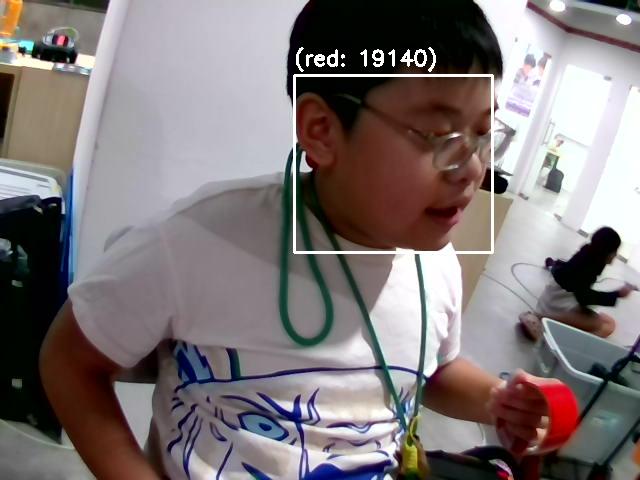

Done


In [ ]:
import numpy as np
import cv2
from IPython.display import display, clear_output
from PIL import Image

# Helper function to find the biggest contour
def biggest_contour(mask, min_area=1500):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    # filter by area to reduce noise
    contours = [c for c in contours if cv2.contourArea(c) >= min_area]
    if not contours:
        return None
    return max(contours, key=cv2.contourArea)

COLOR_RANGES = {
    'red' : [(np.array([0, 120, 70]), np.array([10, 255, 255])), 
             (np.array([170, 120, 70]), np.array([179, 255, 255]))],
    'blue' : [(np.array([90, 80, 80]), np.array([130, 255, 255]))]
}

# Morphology kernel
KERNEL = np.ones((5, 5), np.uint8)

got.open_camera()

try:
    while True:
        frame = got.read_camera_data()
        if frame is not None:
            nparr = np.frombuffer(frame, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            # Blur to reduce noise
            blurred = cv2.GaussianBlur(img, (5, 5), 0)
            hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

            # ADDED
            best_name = None
            best_cnt = None
            best_area = 0
            # END ADDED

            for name, ranges in COLOR_RANGES.items():
                mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
                for lo, hi in ranges:
                    mask = cv2.bitwise_or(mask, cv2.inRange(hsv, lo, hi))

                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, KERNEL, iterations=1)
                mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, KERNEL, iterations=1)

                # Find largest blob
                cnt = biggest_contour(mask, min_area=10000)
                if cnt is not None:
                    area = cv2.contourArea(cnt)

                    # ADDED
                    if area > best_area:
                        best_area = area
                        best_cnt = cnt
                        best_name = name
                    # END ADDED

                    x, y, w, h = cv2.boundingRect(cnt)
                    label = f"({name}: {int(area)})"
                    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)
                    cv2.putText(img, label, (x, y - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            # ADDED
            if best_name == "blue":
                forward(25, 25)
            elif best_name == "red":
                left(25, 25)
            else:
                stop()
            # END ADDED

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Convert to PIL Image for display
            img_pil = Image.fromarray(img_rgb)

            # Clear previous output and display new frame
            clear_output(wait=True)
            display(img_pil)
except KeyboardInterrupt:
    print("Done")
    stop()


## Line Following

In [ ]:
got.load_models(["line_recognition"])
got.set_track_recognition_line(0)

try:
    while True:
        line_following(0.18, 25)
except KeyboardInterrupt:
    stop()
    print("done")

## Maze solving

In [6]:
try:
    while True:
        maze(10)
except KeyboardInterrupt:
    stop()